# Correlation Matrix

## Define Functions

In [227]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [26]:
def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    return num_rows, num_cols

In [27]:
def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

In [28]:
def mean(x):
    return sum(x) / len(x)

In [29]:
def de_mean(x):
    """translate x by subtracting its mean (so the result has mean 0)"""
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

In [30]:
def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

In [31]:
def variance(x):
    """assumes x has at least two elements"""
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

In [32]:
def standard_deviation(x):
    return math.sqrt(variance(x))

In [33]:
def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n - 1)

In [34]:
def correlation(x, y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(x, y) / stdev_x / stdev_y
    else:
        return 0 # if no variation, correlation is zero

In [35]:
def get_column(A, j):
    return [A_i[j] for A_i in A]

In [36]:
def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix
    whose (i,j)-th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j) for j in range(num_cols)]
            for i in range(num_rows)]

In [37]:
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry
    is the correlation between columns i and j of data"""

    _, num_columns = shape(data)

    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))

    return np.array(make_matrix(num_columns, num_columns, matrix_entry))

In [118]:
def display_correlation_matrix(data, series_labels=None):
    _, num_columns = shape(data)
    fig, ax = plt.subplots(num_columns, num_columns, figsize=(64,44))

    series_label_counter = 0
    for i in range(num_columns):
        for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
            if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))

            # unless i == j, in which case show the series name
            else:
                if series_labels is None:
                    ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                      xycoords='axes fraction',
                                      ha="center", va="center")
                else:
                    label = series_labels[series_label_counter]
                    ax[i][j].annotate(label, (0.5, 0.5),
                                      xycoords='axes fraction',
                                      ha="center", va="center")
                    series_label_counter += 1
            
            # Set the x and y limits
            jmi = min(get_column(data, j))
            jma = max(get_column(data, j))
            ax[i][j].set_xlim((jmi, jma))
            imi = min(get_column(data, i))
            ima = max(get_column(data, i))
            ax[i][j].set_ylim((imi, ima))

            # then hide axis labels except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())

    plt.show()

In [109]:
def display_matrix(matrix):
    
    for n, row in enumerate(matrix):
        for m, element in enumerate(row):
            
            if (n == 0) and (m == 0):
                line = '['
            elif (m == 0):
                line = ' '
            else:
                line += ' '*2
            
            line += f"{element: .4f}"
            
            if (n == len(matrix)-1) and (m == len(row)-1):
                line += ' ]'
        print(line)
            

## Import Data 

In [228]:
bkg_file = "pp_2mu2e_bkg"
signal_file = "pp_h_2mu2e_heft"

In [111]:
from reconstruction import Reco, addReco, PDT
from events import Event, load_events, select_observables

In [112]:
bkg_events = load_events(bkg_file)
signal_events = load_events(signal_file)

In [113]:
lepton_observables = {}
lepton_observables[11] = lambda elctn: (elctn.E, elctn.perp, elctn.m, elctn.rap,)
lepton_observables[13] = lambda muon: (muon.E, muon.perp, muon.m, muon.rap,)

bkg_data, signal_data = select_observables(bkg_events, signal_events, lepton_observables)
num_each_particle = {"\mu_":2, "e_":2}
observable_order = ("$\mu_{E}$", "$\mu_{p_T}$", "$\mu_m$", "$\mu_{rap}$", "$e_{E}$", "$e_{p_T}$", "$e_m$", "$e_{rap}$")
label = "$\mu_{E}$ & $\mu_{p_T}$ & $\mu_m$ & $\mu_{rap}$ & $e_{E}$ & $e_{p_T}$ & $e_m$ & $e_{rap}$ | (GeV)"

In [114]:
bkg_data = [datum[0] for datum in bkg_data]
signal_data = [datum[0] for datum in signal_data]
bkg_data = np.array(bkg_data)
signal_data = np.array(signal_data)

## Find Correlation Matrix

In [115]:
series_labels = ("$\mu_{E}^{1}$", "$\mu_{p_T}^{1}$", "$\mu_{m}^{1}$", "$\mu_{rap}^{1}$", "$\mu_{E}^{2}$", "$\mu_{p_T}^{2}$", "$\mu_{m}^{2}$", "$\mu_{rap}^{2}$",
                 "$e_{E}^{1}$", "$e_{p_T}^{1}$", "$e_{m}^{1}$", "$e_{rap}^{1}$", "$e_{E}^{2}$", "$e_{p_T}^{2}$", "$e_{m}^{2}$", "$e_{rap}^{2}$")

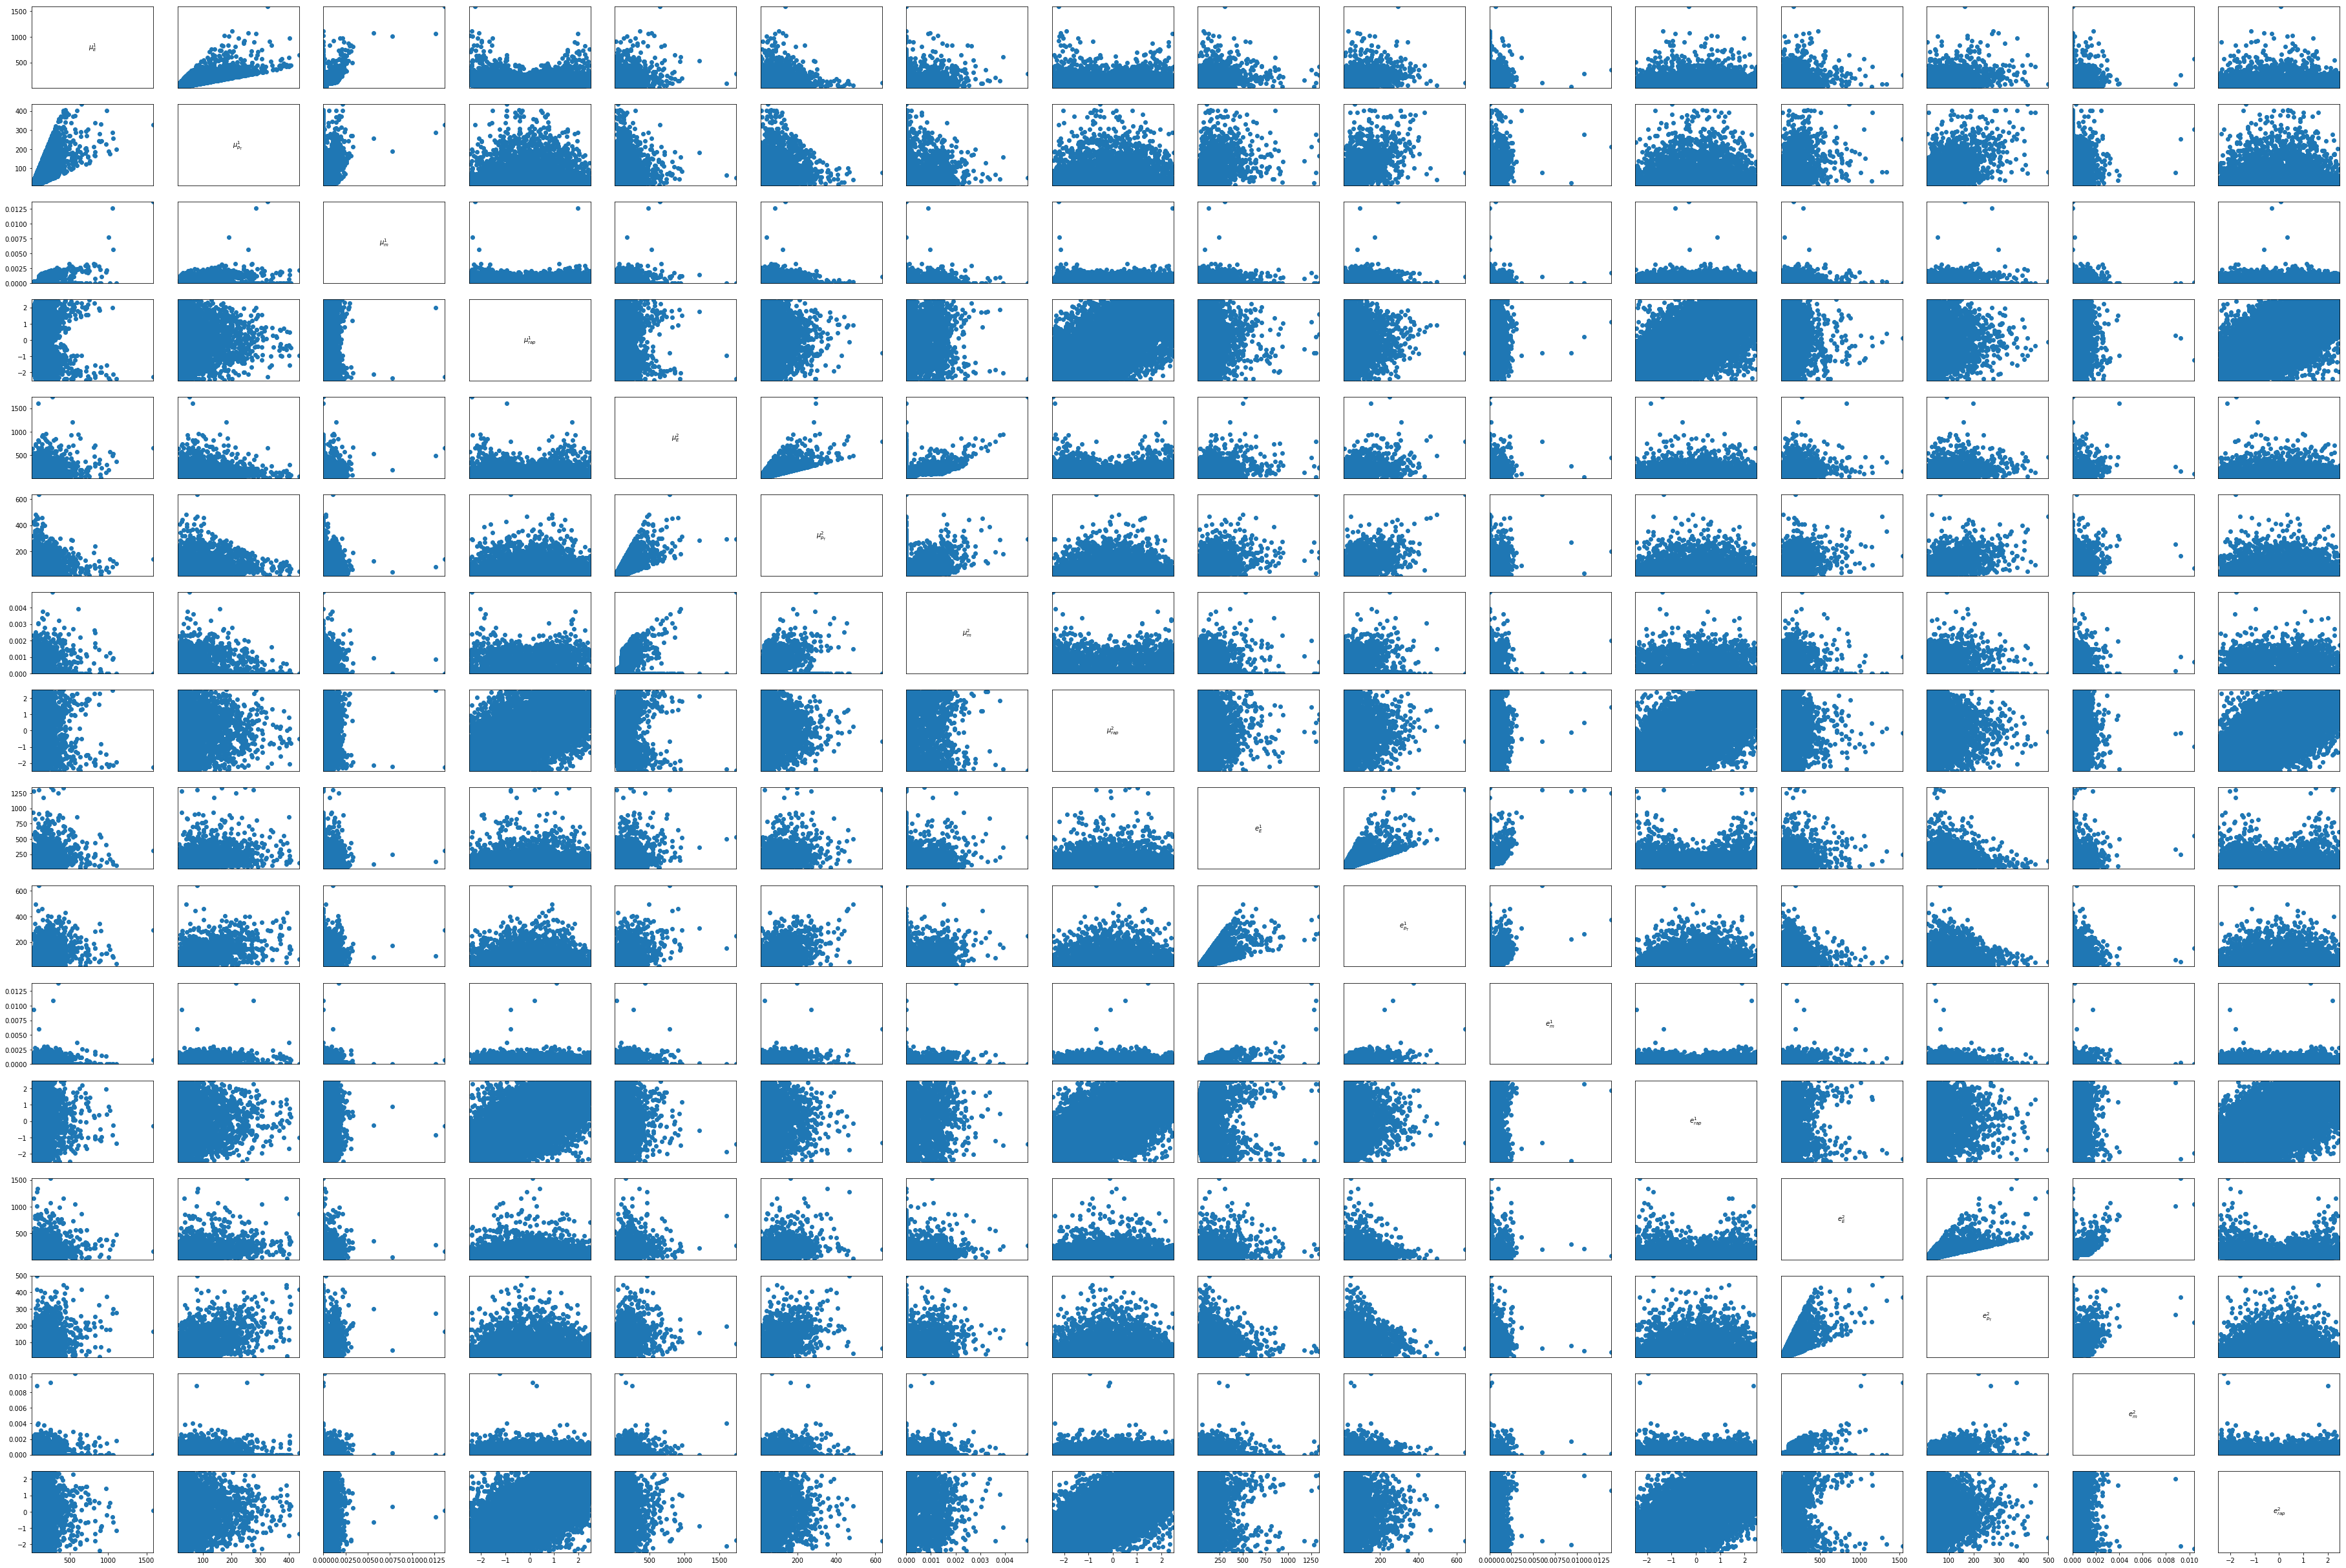

[ 1.0000   0.7878   0.5506  -0.0182   0.4649   0.3761   0.2693  -0.0153   0.4272   0.4986   0.2241   0.0026   0.4145   0.5016   0.2278  -0.0105
  0.7878   1.0000   0.4041  -0.0156   0.3930   0.4693   0.2289  -0.0113   0.5004   0.6459   0.2728  -0.0018   0.4878   0.6417   0.2635  -0.0115
  0.5506   0.4041   1.0000  -0.0087   0.2538   0.1979   0.1479  -0.0075   0.2146   0.2596   0.1116  -0.0004   0.2105   0.2594   0.1005  -0.0091
 -0.0182  -0.0156  -0.0087   1.0000  -0.0074  -0.0050   0.0046   0.5543  -0.0072  -0.0064  -0.0086   0.5630  -0.0128  -0.0128  -0.0029   0.5436
  0.4649   0.3930   0.2538  -0.0074   1.0000   0.7876   0.5347  -0.0057   0.4664   0.5183   0.2339   0.0054   0.4380   0.4909   0.2352  -0.0036
  0.3761   0.4693   0.1979  -0.0050   0.7876   1.0000   0.4237  -0.0031   0.5271   0.6484   0.2890   0.0011   0.5211   0.6388   0.2779  -0.0017
  0.2693   0.2289   0.1479   0.0046   0.5347   0.4237   1.0000   0.0010   0.2461   0.2845   0.1274   0.0080   0.2357   0.2717   0.1424  

In [120]:
display_correlation_matrix(signal_data, series_labels=series_labels)
signal_matrix = correlation_matrix(signal_data)
display_matrix(signal_matrix)

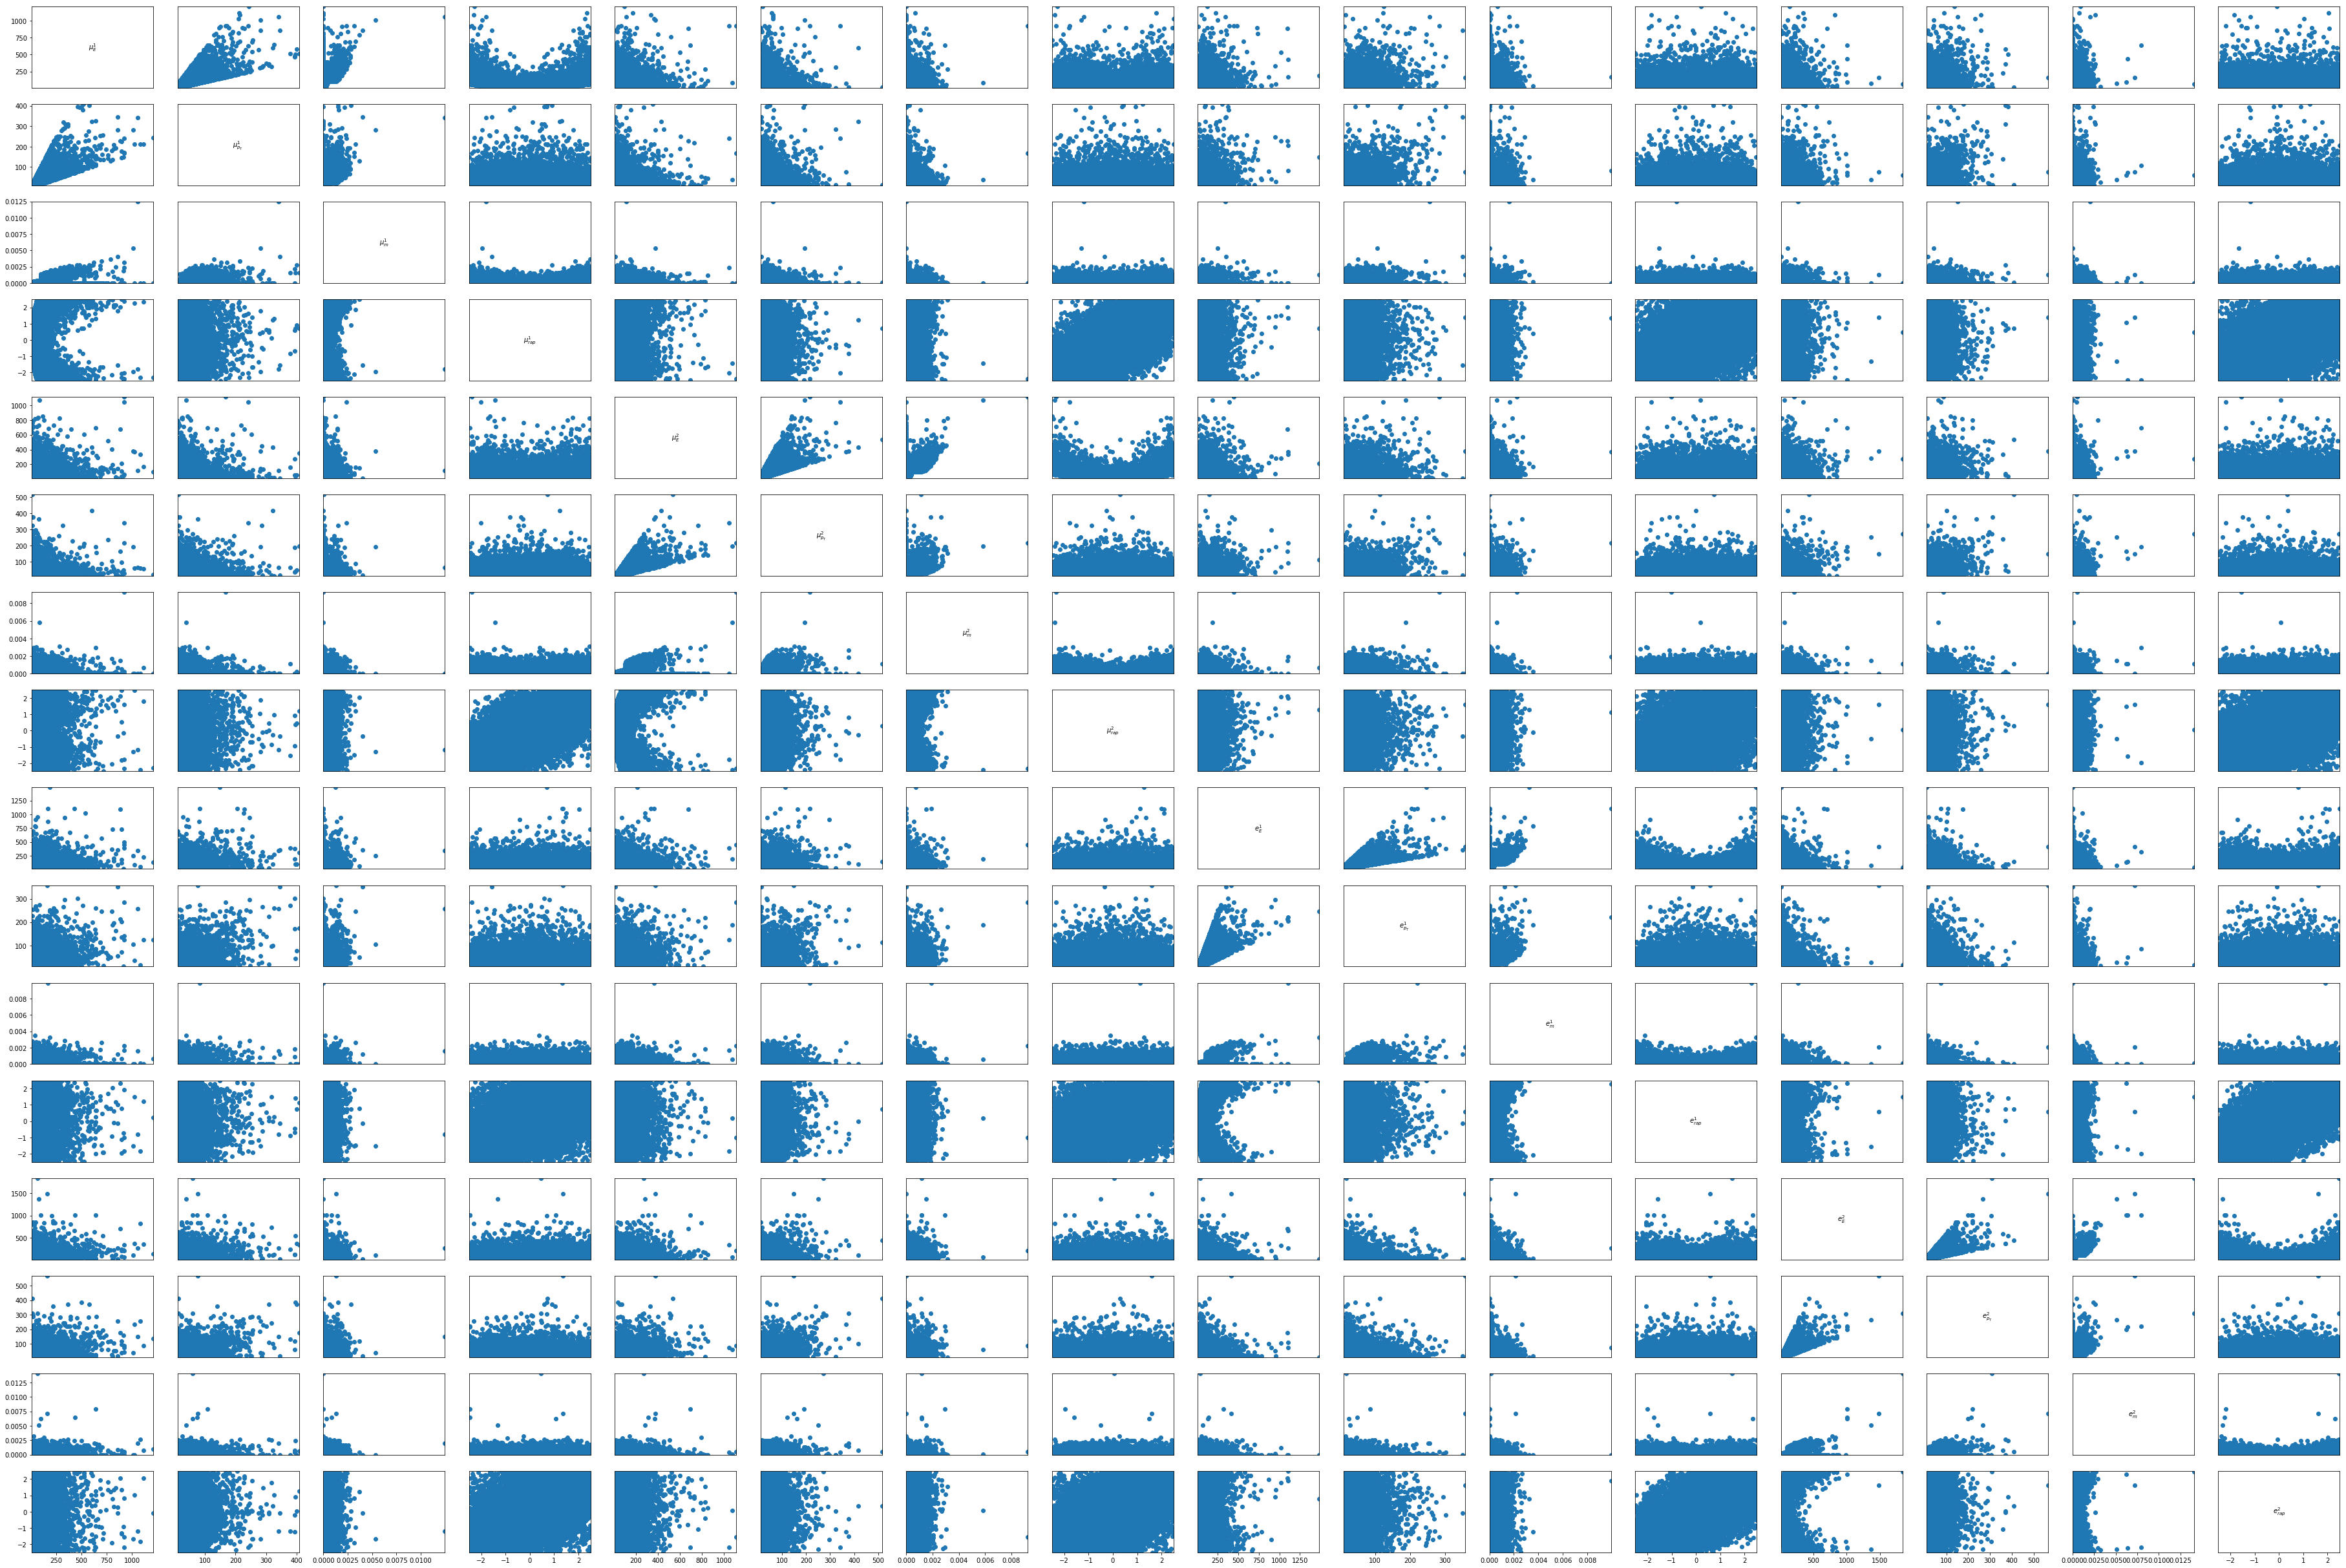

[ 1.0000   0.6980   0.4890  -0.0019   0.1383  -0.0015   0.0791  -0.0091   0.2288   0.2858   0.1033  -0.0005   0.2219   0.2694   0.1250  -0.0035
  0.6980   1.0000   0.3687   0.0042   0.0066   0.0040  -0.0081  -0.0161   0.2591   0.3968   0.1028   0.0104   0.2453   0.3880   0.1218   0.0030
  0.4890   0.3687   1.0000  -0.0000   0.0574   0.0060   0.0255  -0.0064   0.1254   0.1514   0.0713  -0.0032   0.0983   0.1396   0.0544  -0.0104
 -0.0019   0.0042  -0.0000   1.0000   0.0027   0.0026  -0.0016   0.5745   0.0071   0.0090  -0.0079   0.4118   0.0002   0.0014   0.0010   0.4379
  0.1383   0.0066   0.0574   0.0027   1.0000   0.6744   0.4950   0.0101   0.2070   0.2509   0.0950   0.0034   0.2294   0.2702   0.1143   0.0110
 -0.0015   0.0040   0.0060   0.0026   0.6744   1.0000   0.3204  -0.0006   0.2448   0.3561   0.1124  -0.0092   0.2790   0.3917   0.1465  -0.0036
  0.0791  -0.0081   0.0255  -0.0016   0.4950   0.3204   1.0000   0.0107   0.1037   0.1378   0.0574   0.0035   0.1228   0.1249   0.0813  

In [121]:
display_correlation_matrix(bkg_data, series_labels=series_labels)
bkg_matrix = correlation_matrix(bkg_data)
display_matrix(bkg_matrix)

In [132]:
import pandas as pd
import seaborn as sns

In [169]:
sns.set(style="white")

In [174]:
sgn_df = pd.DataFrame(data=signal_data,
                      columns=series_labels)
sgn_df['class']=1

In [180]:
bkg_df = pd.DataFrame(data=bkg_data,
                      columns=series_labels)
bkg_df['class']=0

In [183]:
all_df = pd.concat([sgn_df, bkg_df])

In [193]:
all_df.head

<bound method NDFrame.head of       $\mu_{E}^{1}$  $\mu_{p_T}^{1}$  $\mu_{m}^{1}$  $\mu_{rap}^{1}$  \
0         66.494157        44.736951       0.000000         0.950101   
1         51.185606        49.083716       0.000230         0.291617   
2         16.991804        16.965725       0.000000        -0.055440   
3         10.731395        10.229641       0.000091        -0.311940   
4         15.248995        14.650262       0.000000         0.284932   
5         56.615111        26.061162       0.000297         1.411217   
6         15.052826        13.382454       0.000147        -0.494580   
7         43.528227        16.015856       0.000094         1.657272   
8         52.296503        44.882625       0.000132        -0.567144   
9         15.251951        12.968242       0.000132         0.585083   
10       117.613439        28.746832       0.000566        -2.086742   
11        31.301543        20.426306       0.000000        -0.990868   
12        37.920383        11.2618

In [206]:
E = all_df['$\mu_{E}^{1}$'] + all_df['$\mu_{E}^{2}$'] + all_df['$e_{E}^{1}$'] + all_df['$e_{E}^{2}$']

In [199]:
P = all_df['$\mu_{p_T}^{1}$'] + all_df['$\mu_{p_T}^{2}$'] + all_df['$e_{p_T}^{1}$'] + all_df['$e_{p_T}^{2}$']

In [200]:
E_sq = E * E
P_sq = P * P
m_H_sq = E_sq - P_sq
m_H = m_H_sq**0.5

In [220]:
all_df['$m_{H}$'] = m_H

In [221]:
cols = all_df.columns.tolist()
cols = cols[:-2] + cols[-1:] + cols[-2:-1]
all_df = all_df[cols]

In [224]:
# Compute the correlation matrix
corr = all_df.corr()

In [225]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

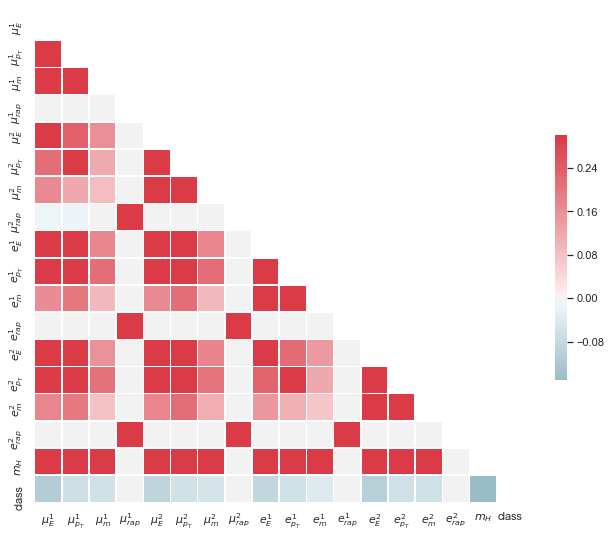

In [226]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [137]:
display_matrix(signal_matrix)

[ 1.0000   0.7878   0.5506  -0.0182   0.4649   0.3761   0.2693  -0.0153   0.4272   0.4986   0.2241   0.0026   0.4145   0.5016   0.2278  -0.0105
  0.7878   1.0000   0.4041  -0.0156   0.3930   0.4693   0.2289  -0.0113   0.5004   0.6459   0.2728  -0.0018   0.4878   0.6417   0.2635  -0.0115
  0.5506   0.4041   1.0000  -0.0087   0.2538   0.1979   0.1479  -0.0075   0.2146   0.2596   0.1116  -0.0004   0.2105   0.2594   0.1005  -0.0091
 -0.0182  -0.0156  -0.0087   1.0000  -0.0074  -0.0050   0.0046   0.5543  -0.0072  -0.0064  -0.0086   0.5630  -0.0128  -0.0128  -0.0029   0.5436
  0.4649   0.3930   0.2538  -0.0074   1.0000   0.7876   0.5347  -0.0057   0.4664   0.5183   0.2339   0.0054   0.4380   0.4909   0.2352  -0.0036
  0.3761   0.4693   0.1979  -0.0050   0.7876   1.0000   0.4237  -0.0031   0.5271   0.6484   0.2890   0.0011   0.5211   0.6388   0.2779  -0.0017
  0.2693   0.2289   0.1479   0.0046   0.5347   0.4237   1.0000   0.0010   0.2461   0.2845   0.1274   0.0080   0.2357   0.2717   0.1424  